In [ ]:
pip install langchain langchain_community langchain_groq sentence_transformers chromadb faiss-cpu langgraph

In [ ]:
pip install langchain_tavily

In [1]:
import os
from google.colab import userdata

GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

LANGSMITH_API_KEY = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_API_KEY'] = LANGSMITH_API_KEY

In [2]:
import warnings
warnings.simplefilter('ignore')

In [35]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

from langchain_groq import ChatGroq
llm = ChatGroq(model_name="gemma2-9b-it")

In [29]:
from langchain_community.document_loaders import WebBaseLoader
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [30]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=25
)
doc_splits = text_splitter.split_documents(docs_list)

In [31]:
from langchain.vectorstores import Chroma
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [32]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(retriever=retriever,
                      name= "retriever-blog-post",
                      description="Search and return the information of lilianweng blog posts on LLM Agents and Promptengineering")

In [33]:
tools = [retriever_tool]

In [11]:
from langgraph.prebuilt import ToolNode
retrieve = ToolNode([retriever_tool])

In [12]:
from typing_extensions import TypedDict, List, Annotated, Sequence, Literal
from langchain.schema import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    rewrite_count: int

In [13]:
from pydantic import BaseModel, Field
class GradeDocs(BaseModel):
  binary_score: str = Field(description="Relevance Score 'Yes' or 'No' ")

In [14]:
def assistant(state: AgentState):
    print("---CALL AGENT---")
    messages = state["messages"]
    llm_with_tool = llm.bind_tools(tools)
    response = llm_with_tool.invoke(messages)
    return {
        "messages": [response]
    }

In [15]:
from langchain_core.messages import ToolMessage
from langchain.prompts import PromptTemplate

def grade_docs(state: AgentState) -> Literal["Generate", "Query_Rewriter"]:
    llm_with_structure_op = llm.with_structured_output(GradeDocs)

    prompt = PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
        Here is the document: {context}
        Here is the user’s question: {question}
        If the document talks about or contains information related to the user’s question, mark it as relevant.
        Give a 'yes' or 'no' answer.""",
        input_variables=["context", "question"]
    )
    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    context = last_message.content[:1500].strip()

    result = chain.invoke({"question": question, "context": context})
    score = result.binary_score.lower().strip()

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "Generate"
    else:
        if state.get("rewrite_count", 0) >= 1:
            print("---DECISION: DOCS NOT RELEVANT AFTER REWRITE — GENERATE ANYWAY---")
            return "Generate"
        else:
            print("---DECISION: DOCS NOT RELEVANT — TRY REWRITE---")
            return "Query_Rewriter"

In [54]:
from langchain import hub
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage
def generate(state: AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm

    if not docs or len(docs.strip()) < 50:
        response = AIMessage(content="No relevant documents were found, but here's a general answer: An agent is a system that acts on behalf of others.")
    else:
        response = rag_chain.invoke({"context": docs, "question": question})

    print(f"this is my response:{response}")
    return {"messages": [response]}

In [55]:
from langchain_core.messages import HumanMessage
def rewrite(state: AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    new_message = [HumanMessage(content=f"Improve this unclear question: {question}")]
    response = llm.invoke(new_message)

    return {
        "messages": [response],
        "rewrite_count": state.get("rewrite_count", 0) + 1
    }

In [56]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

graph = StateGraph(AgentState)

graph.add_node("Assistant", assistant)
graph.add_node("Vector_Retriever", ToolNode([retriever_tool]))
graph.add_node("Generate", generate)
graph.add_node("Query_Rewriter", rewrite)

graph.add_edge(START, "Assistant")
graph.add_conditional_edges("Assistant", tools_condition, {
    "tools": "Vector_Retriever",
    END: END
})

graph.add_conditional_edges("Vector_Retriever", grade_docs, {
    "Generate": "Generate",
    "Query_Rewriter": "Query_Rewriter"
})

graph.add_edge("Generate", END)
graph.add_edge("Query_Rewriter", "Assistant")

builder = graph.compile()

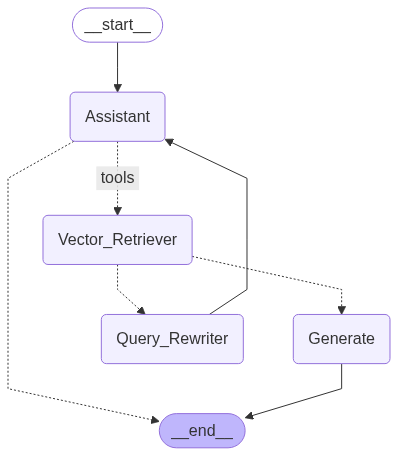

In [57]:
builder

In [58]:
builder.invoke({
    "messages": [HumanMessage(content="What is an Agent?")]
})

---CALL AGENT---
---DECISION: DOCS RELEVANT---
---GENERATE---
this is my response:content='An agent is a system that can act autonomously to achieve goals.  LLM-powered autonomous agents use large language models to plan, remember, and utilize tools to accomplish tasks.  They are capable of complex interactions with their environment. \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 469, 'total_tokens': 521, 'completion_time': 0.094545455, 'prompt_time': 0.010302455, 'queue_time': 0.019247651999999997, 'total_time': 0.10484791}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--12564080-1cf0-4c3a-b716-355cc042e5cc-0' usage_metadata={'input_tokens': 469, 'output_tokens': 52, 'total_tokens': 521}


{'messages': [HumanMessage(content='What is an Agent?', additional_kwargs={}, response_metadata={}, id='ab0055ce-d8c1-40bd-9adc-6f061821e947'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ds4z09pmd', 'function': {'arguments': '{"query":"an agent"}', 'name': 'retriever-blog-post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 975, 'total_tokens': 1061, 'completion_time': 0.156363636, 'prompt_time': 0.023115919, 'queue_time': 0.019695627, 'total_time': 0.179479555}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3e2d7a4b-a873-4d50-9c3c-e903808a9088-0', tool_calls=[{'name': 'retriever-blog-post', 'args': {'query': 'an agent'}, 'id': 'ds4z09pmd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 975, 'output_tokens': 86, 'total_tokens': 1061}),
  ToolMessage(content="Citation#\nCited as:\n\nWeng, Lili

In [59]:
from pprint import pprint
from langchain_core.messages import HumanMessage

# Start input
inputs = {"messages": [HumanMessage(content="Tell about the agent memory?")]}

# Stream execution through the graph
for step in builder.stream(inputs):
    for key, value in step.items():
        pprint(f"Node '{key}':")
        pprint(value)
    pprint("\n---\n")

final_state = value

if "messages" in final_state:
    final_message = final_state["messages"][-1]
    pprint("Final Generation:")
    pprint(final_message.content)

---CALL AGENT---
"Node 'Assistant':"
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nc6zak1zs', 'function': {'arguments': '{"query":"agent memory"}', 'name': 'retriever-blog-post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 976, 'total_tokens': 1062, 'completion_time': 0.156363636, 'prompt_time': 0.023508389, 'queue_time': 0.019100599, 'total_time': 0.179872025}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--73d9c9a4-3542-4d02-89c7-6fe98e5c3049-0', tool_calls=[{'name': 'retriever-blog-post', 'args': {'query': 'agent memory'}, 'id': 'nc6zak1zs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 976, 'output_tokens': 86, 'total_tokens': 1062})]}
'\n---\n'
---DECISION: DOCS RELEVANT---
"Node 'Vector_Retriever':"
{'messages': [ToolMessage(content="They also discussed the risks, especially

In [60]:
inputs = {
    "messages": [HumanMessage(content="What is a Agent?")],
    "rewrite_count": 0
}

for step in builder.stream(inputs):
    for key, value in step.items():
        pprint(f"Node '{key}':")
        pprint(value)
    pprint("\n---\n")

final_state = value
if "messages" in final_state:
    final_message = final_state["messages"][-1]
    pprint("Final Generation:")
    pprint(final_message.content)

---CALL AGENT---
"Node 'Assistant':"
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ptwh1sbhe', 'function': {'arguments': '{"query":"What is an Agent?"}', 'name': 'retriever-blog-post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 975, 'total_tokens': 1063, 'completion_time': 0.16, 'prompt_time': 0.01875521, 'queue_time': 0.021042237, 'total_time': 0.17875521}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--25947f61-ba13-46c8-be39-a676c8e815ef-0', tool_calls=[{'name': 'retriever-blog-post', 'args': {'query': 'What is an Agent?'}, 'id': 'ptwh1sbhe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 975, 'output_tokens': 88, 'total_tokens': 1063})]}
'\n---\n'
---DECISION: DOCS RELEVANT---
"Node 'Vector_Retriever':"
{'messages': [ToolMessage(content="Planning & Reacting: translate the refle

In [61]:
inputs = {
    "messages": [HumanMessage(content="What is the Capital Of India?")],
    "rewrite_count": 0
}

for step in builder.stream(inputs):
    for key, value in step.items():
        pprint(f"Node '{key}':")
        pprint(value)
    pprint("\n---\n")

final_state = value
if "messages" in final_state:
    final_message = final_state["messages"][-1]
    pprint("Final Generation:")
    pprint(final_message.content)

---CALL AGENT---
"Node 'Assistant':"
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '46fhhg12p', 'function': {'arguments': '{"query":"What is the capital of India?"}', 'name': 'retriever-blog-post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 977, 'total_tokens': 1066, 'completion_time': 0.161818182, 'prompt_time': 0.018744391, 'queue_time': 0.020336576000000002, 'total_time': 0.180562573}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ad2c6ce4-ba0f-4d71-91ca-9e63fc80f3e0-0', tool_calls=[{'name': 'retriever-blog-post', 'args': {'query': 'What is the capital of India?'}, 'id': '46fhhg12p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 977, 'output_tokens': 89, 'total_tokens': 1066})]}
'\n---\n'
---DECISION: DOCS NOT RELEVANT — TRY REWRITE---
"Node 'Vector_Retriever':"
{'messages': [T